In [1]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Testing Detection Pipeline

In [2]:
ranges_df=pd.read_csv("A3_Range_truth_dot256ms.csv")
truthData=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A3_flight_directory.csv")

In [25]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score,f1_score
import pickle
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score
import datetime
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-3","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "Drone": [1, 0],
    "Noise": [0, 1]
}
def grabRange(cellName, pass_df,frame):
    phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==cellName]
    frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==frame]
    return float(frame_df[str(notable_col_names.index('Range'))])


def findClosestPhone(phoneRanges): #phoneList is a list of all N phone ranges
    closest_range=10000
    best_prediction=0
    for x in phoneRanges:
        phone_dist=x[0]
        if phone_dist<closest_range:
            best_prediction=x[1]
            closest_range=phone_dist

    if closest_range <=80:
        truth_val=1
    else:
        truth_val=0
    return best_prediction, truth_val


mean_std=pd.read_csv("mean_std_training_ds_wo_A1.csv")
mean=np.array(mean_std.loc[:,'mean'])
std=np.array(mean_std.loc[:,'std'])

In [213]:
NOISE=0
DRONE=1
# usable_phones=["Phone_1-3.wav",
# "Phone_2-4.wav",
# "Phone_6-2.wav", #gps n/a
# "Phone_6-3.wav",
# "Phone_6-4.wav", #gps n/a
# "Phone_6-5.wav",
# "Phone_7-2.wav",
# "Phone_9.wav"
# ]
def findClosestPhone(phoneRanges): #phoneList is a list of all N phone ranges
    closest_range=10000
    best_prediction=0
    for x in phoneRanges:
        phone_dist=x[0]
        if phone_dist<closest_range:
            best_prediction=x[1]
            closest_range=phone_dist

    if closest_range <=80:
        truth_val=1
    else:
        truth_val=0
    return int(best_prediction), truth_val

def weighting(maxVals):
    layer = tf.keras.layers.Softmax(axis=-1)
    weights=layer(maxVals)
    return weights
#json_file=open(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\models\1DCNN_PL_V3(final).json", 'r')
json_file=open(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\ANN_LT80_wo_A1_A3_added.json", 'r')
loaded_network_json = json_file.read()
json_file.close()
loaded_network = tf.keras.models.model_from_json(loaded_network_json)
#loaded_network.load_weights(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\models\1DCNN_PL_V3(final)").expect_partial()
loaded_network.load_weights(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\ANN_LT80_wo_A1_A3_added").expect_partial()

loaded_network.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)

filename = 'finalized_svm_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=2048,n_fft=2048,n_mfcc=40, sr=Fs)
    return coefs

def split_test_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    duration = waveData.shape[0]
    features=MFCCCalc(waveData.squeeze(),Fs=8000)
    label= [droneDict[labelName]] * features.shape[1]
    return features, label
def create_test_dataset(test_files, testTime,testName):
    """
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    featuresLL=[]
    numPhones=0
    pass_df=ranges_df.loc[ranges_df[str(notable_col_names.index('Pass'))] == testName]
    for x in test_files:
        phoneName = x.split('\\')[7][:-4]
        test_audio, sampleRate = librosa.load(x, sr=8000)
        if len(test_audio) == (testTime)*sampleRate and min(np.asarray(test_audio)) != 0: #ensure data actually has sound and recorded correctly
    #if x.split('\\')[7] in usable_phones:
            numPhones+=1
            x = str(x)
            #print(x.split('\\')[7])
            phoneName = x.split('\\')[7][:-4]
            #label = label[6]
            #test_audio = test_audio[0: (testTime-1)*sampleRate]  # trim to nearest second removed for consistency sake
            newFeats=MFCCCalc(test_audio.squeeze(),Fs=8000)
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phoneName]
            if len(np.array(phone_seg.iloc[:,7]))>0:
                featuresLL.append([phoneName,newFeats.transpose(),np.array(phone_seg.iloc[:,7])])
    return featuresLL

def maxValues(features):
    maxVals=[]
    for x in features:
        #maxVals.append(abs(x).max())
        #print("val:",(x[0][0]))
        maxVals.append(x[0]) #average power of signal
    return maxVals

def phoneAccuracy(phoneRanges):
    return phoneRanges < 80

def majorityVoteNew(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        #features_list= np.reshape(features_list, (len(features_list), 40, 1))
        maxVals.append(maxValues(features_list))
        #pred=loaded_model.predict(features_list)[:] > 0.50
        pred= loaded_network.predict(features_list)[:] > 0.5
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    #maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    #maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    indiv_predictedList=[]
    truth_valueList=[]
    prevState=4
    rounding=len(y_prediction[0])/len(testFeats[0][2])
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][int(i/rounding)],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >0.2: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        prevState, prediction=threeBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        indiv_predictedList.append(best_indiv_predict)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,indiv_predictedList,truth_valueList

def zeroBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=0
    else:
        predVal=1
    return prevPredictState, predVal

def twoBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>1:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>3:
        prevPredictState=3
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def threeBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>3:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>7:
        prevPredictState=7
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def fourBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>15:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>31:
        prevPredictState=31
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction
testTime=90
truthScenario = truthData.iloc[0]
pass_num=truthScenario[0]
scenario=truthScenario[1]
run_num=truthScenario[2]
start=truthScenario[3]
stop=truthScenario[4]
drone_gps_file=truthScenario[5]
start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
testTime= int(stop_time-start_time)
dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\A3\\A3R4P3" #TODO
Testdata_dir = pathlib.Path(dataset_path)
phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
# oldTF= testFeatures
# oldTT =testTargets
featuresLL =create_test_dataset(phones, testTime, testName="A3R4P3")
predictedList, y_prediction,indiv_predictedList,truth_valueList= majorityVoteNew(featuresLL)
indiv_accuracies=[]
for x in range(len(featuresLL)):
    if len(featuresLL[x][2]>0):
        val=featuresLL[x][2]<80
        indiv_accuracies.append(accuracy_score(y_true=val,y_pred=y_prediction[x][0:750]))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
count=1
for x in range(len(featuresLL)):
    # if len(featuresLL[x][2]>0):
    #     plt.title(featuresLL[x][0])
    #     plt.plot(featuresLL[x][2][0:len(y_prediction[0])],y_prediction[x])
    #     plt.figure()
    if len(featuresLL[x][2]>0) and (featuresLL[x][0]== "Phone_9" or featuresLL[x][0]== "Phone_3-5"):
        plt.subplot(1,2,count)
        plt.title(featuresLL[x][0])
        #plt.plot(featuresLL[x][2][0:len(y_prediction[0])],featuresLL[x][2][0:len(y_prediction[0])]<80)
        plt.plot(featuresLL[x][2][0:len(y_prediction[0])],y_prediction[x])
        plt.xlabel("Range From Cellphone")
        plt.ylabel("sUAS Detection Prediction")
        #plt.plot(range(0,len(y_prediction[0])),y_prediction[x])
        count+=1
#plt.savefig("./Plots/CellphoneMic_software_errorsV1.pdf",bbox_inches="tight")
print("Indiv Accuracy", np.average(indiv_accuracies))
print("DFP Accuracy",accuracy_score(y_true=truth_valueList,y_pred=predictedList))
print("Phone Accuracy",accuracy_score(y_true=truth_valueList,y_pred=indiv_predictedList))
# plt.plot(predictedList)
# plt.plot(truth_valueList)
#plt.plot(classPrediction)


KeyboardInterrupt



# Model Tuning

In [30]:

tuning_runs=["A3R5P3","A3R4P2","A3R6P3"]
start=0
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]

def majorityVoteTuning(testFeats, fusionThresh,networkThresh, FSMVal):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        #features_list= np.reshape(features_list, (len(features_list), 40, 1))
        maxVals.append(maxValues(features_list))
        pred=loaded_network.predict(features_list)[:] > networkThresh
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    predictedList=[]
    indiv_predictedList=[]
    truth_valueList=[]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >fusionThresh: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        indiv_predictedList.append(best_indiv_predict)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,indiv_predictedList,truth_valueList

def tuning(fusion_thresholds,net_thresholds,FSMS):
    best_fusion=0.0
    best_network=0.0
    best_score=0.0
    best_FSM=0
    for fus_thresh in fusion_thresholds:
        for fsm in FSMS:
            for net_thresh in net_thresholds:
                novelAve=[]
                print(fus_thresh,net_thresh,fsm)
                for x in range(18):
                    indiv_scores=[]
                    truthScenario = truthData.iloc[x]
                    pass_num=truthScenario[0]
                    scenario=truthScenario[1]
                    run_num=truthScenario[2]
                    start=truthScenario[3]
                    stop=truthScenario[4]
                    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
                    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
                    testTime= int(stop_time-start_time)
                    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
                    if full_name in tuning_runs:
                        #read scenario and truth data
                        name=truthScenario[0]
                        startDetect= truthScenario[1]
                        endDetect=truthScenario[2]
                        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_v2\\A3\\"+full_name
                        Testdata_dir = pathlib.Path(dataset_path)
                        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
                        # convert to MFCC space
                        featuresLL =create_test_dataset(phones, testTime, testName=full_name)
                        predictedList, y_prediction,indiv_predictedList,truth_valueList= majorityVoteTuning(featuresLL,fus_thresh,net_thresh,fsm)
                        #
                        for z in range(len(featuresLL)): #iterate over cellphones
                                    if len(featuresLL[z][2]>0):
                                        val=featuresLL[z][2]<80
                                        indiv_scores.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                        # Report balanced accuracy scores
                        #################### Score Reporting #################
                        #best_phone_score=np.average(indiv_scores)
                        fusion_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
                        novelAve.append(fusion_score)
                        #novelAve.append(best_phone_score)
                        print(np.average(novelAve))
                if np.average(novelAve) > best_score:
                    best_fusion=fus_thresh
                    best_network=net_thresh
                    best_score=np.average(novelAve)
                    best_FSM=fsm
    print("Best fusion threshold:",best_fusion)
    print("Best network threshold:",best_network)
    print("Best network threshold:",best_FSM)
FSM_vals=[2]
fusion_vals=[0.16,0.18,0.2,0.22,0.24,0.26]
thresh_vals=[0.84,0.86,0.88,0.90,0.92,0.94]
tuning(fusion_vals,thresh_vals,FSM_vals)

0.16 0.84 2
13/13 [==============================] - 0s 627us/step
0.8597285067873304
14/14 [==============================] - 0s 1ms/step
0.8130060158457725
12/12 [==============================] - 0s 1ms/step
0.8371428994527372
0.16 0.86 2
13/13 [==============================] - 0s 2ms/step
0.8755760368663597
14/14 [==============================] - 0s 708us/step
0.825384917657986
12/12 [==============================] - 0s 1ms/step
0.8354616028593348
0.16 0.88 2
13/13 [==============================] - 0s 1ms/step
0.8703703703703703
14/14 [==============================] - 0s 1ms/step
0.824290243550944
12/12 [==============================] - 0s 1ms/step
0.837815117322251
0.16 0.9 2
13/13 [==============================] - 0s 2ms/step
0.8651162790697675
14/14 [==============================] - 0s 976us/step
0.8216631979006426
12/12 [==============================] - 0s 172us/step
0.8334897509813808
0.16 0.92 2
13/13 [==============================] - 0s 2ms/step
0.838095238095238
1

# Performance evaluation

In [218]:
import time
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29", "Phone_3-1","Phone_3-2","Phone_3-3","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
indiv_phone_f1_dict={}
indiv_phone_recall_dict={}
indiv_phone_prec_dict={}
for x in phone_slots:
    indiv_phone_f1_dict[x]=[]
    indiv_phone_prec_dict[x]=[]
    indiv_phone_recall_dict[x]=[]
bad_runs=["A3R3P1","A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
start=0
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A3_flight_directory.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
recall_stddev=[]
score_stddev=[]
phone_count=[]
indiv_precisions=[]
indiv_recalls=[]
indiv_accuracies=[]
indiv_scores=[]
total_pred=[]
total_truth=[]
total_ranges=[]
time_per_prediction=[]
evp_f1=[]
detectable_count=[]
tot_test_time=0
test_truth_evp=[]
test_truth_indiv=[]
def majorityVoteTuning(testFeats, fusionThresh,networkThresh, FSMVal):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        if len(x[2]) > 0:
            #features_list= np.reshape(features_list, (len(features_list), 40, 1))
            maxVals.append(maxValues(features_list))
            start_time=time.perf_counter()
            pred=loaded_network.predict(features_list)[:] > networkThresh
            #pred=loaded_model.predict(features_list)[:]
            end_time=time.perf_counter()
            time_per_prediction.append((end_time-start_time)/len(pred))
            pred.astype(int)
            #pred = model.predict(x.squeeze()) #for SVM
            y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    predictedList=[]
    indiv_predictedList=[]
    truth_valueList=[]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >fusionThresh: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        indiv_predictedList.append(best_indiv_predict)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,indiv_predictedList,truth_valueList

for x in range(18):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    pass_num=truthScenario[0]
    scenario=truthScenario[1]
    run_num=truthScenario[2]
    start=truthScenario[3]
    stop=truthScenario[4]
    drone_gps_file=truthScenario[5]
    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
    testTime= int(stop_time-start_time)
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    print(full_name)
    if full_name not in tuning_runs and full_name not in bad_runs:
        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\A3\\"+full_name
        Testdata_dir = pathlib.Path(dataset_path)
        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
        tot_test_time+=testTime
        # convert to MFCC space
        if full_name== "A3R4P1":
            print()
        featuresLL =create_test_dataset(phones, testTime, testName=full_name)
        predictedList, y_prediction,indiv_predictedList,truth_valueList= majorityVoteTuning(featuresLL,fusionThresh=0.2,networkThresh=0.90,FSMVal=2)
        #predictedList, y_prediction,indiv_predictedList,truth_valueList= majorityVoteAlone(featuresLL,fusionThresh=0.2,networkThresh=0.90,FSMVal=2)
        # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
        #fusion_prediction, y_prediction = majorityVoteNew(featuresLL)
        #
        num_frames=len(predictedList) #length of one scenario in frames
        # y_actual=np.zeros(num_frames)
        # y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
        # Report balanced accuracy scores
        tot_indiv_score=0
        tot_recall_score=0
        tot_precision_score=0
        tot_detectable=np.zeros(num_frames)
        for z in range(len(y_prediction)): #iterate over cellphones
            if len(featuresLL[z][2]>0):
                for range_val in range(len(featuresLL[z][2])):
                    if featuresLL[z][2][int(range_val)]<80:
                        total_ranges.append(featuresLL[z][2][int(range_val)])
                val=featuresLL[z][2]<80
                tot_detectable+=val
                phone_name= featuresLL[z][0]
                if phone_name== "Phone_3-2":
                    print("USED HERE")
                    print(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                    print("--------------")
                total_truth.extend(val)
                total_pred.extend(y_prediction[z][0:len(val)])
                indiv_phone_f1_dict[phone_name].append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_phone_recall_dict[phone_name].append(recall_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_phone_prec_dict[phone_name].append(precision_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_accuracies.append(accuracy_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_recalls.append(recall_score(val,y_prediction[z][0:len(val)]))
                indiv_precisions.append(precision_score(val,y_prediction[z][0:len(val)]))
                indiv_scores.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
        test_truth_evp.extend(truth_valueList)
        test_truth_indiv.extend(featuresLL[0][2]<80)
        #################### Score Reporting #################
        detectable_count.extend(tot_detectable[np.where(tot_detectable!=0)])
        indiv_score_ave=np.average(indiv_scores)
        print(full_name)
        print("Number of used phones:",len(y_prediction))
        fusion_score=accuracy_score(y_true=truth_valueList,y_pred=predictedList)
        fusion_f1_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
        novelAve.append(fusion_score)
        phone_count.append([len(y_prediction),fusion_f1_score])
        print("Average Recall value:", recall_score(truth_valueList,predictedList))
        print("Average Precision value:", precision_score(truth_valueList,predictedList))
        print("Accuracy for drone present:", fusion_score)
        print("Indiv Accuracy for drone present:", indiv_score_ave)
        performanceGain=100*((fusion_f1_score-indiv_score_ave)/indiv_score_ave)
        evp_f1.append(fusion_f1_score)
        outPerform.append(performanceGain)
        recall.append(recall_score(truth_valueList,predictedList))
        precision.append(precision_score(truth_valueList,predictedList))
        # print("Recall score:", recall_score(truth_valueList,predictedList))
        # print("Precision score:", precision_score(truth_valueList,predictedList))
        # print("Novel method outperforms by:", performanceGain, "%")
        print("_________________________")
        if full_name == "A3R4P1":
            print()
        # for x in range(len(featuresLL)):
        #     if len(featuresLL[x][2]>0):
        #         plt.title(featuresLL[x][0])
        #         plt.plot(featuresLL[x][2],y_prediction[x][0:len(featuresLL[x][2])])
        #         #plt.plot(range(0,len(y_prediction[0])),y_prediction[x])
        #         plt.figure()
        # plt.plot(range(0,len(truth_valueList)),truth_valueList)
        # plt.plot(range(0,len(predictedList)),predictedList)

print("Indiv Recall", np.average(indiv_recalls))
print("Indiv Precision", np.average(indiv_precisions))
print("Indiv F1", np.average(indiv_scores))
print("EVP Recall",np.average(recall))
print(" EVP Precision",np.average(precision))
print("EVP Accuracy",np.average(novelAve))
print("EVP F1",np.average(evp_f1))
print("Indiv Accuracy", np.average(indiv_accuracies))
print("Outperform",np.average(outPerform))

A3R3P1
A3R3P2
12/12 [==============================] - 0s 1ms/step
A3R3P2
Number of used phones: 16
Average Recall value: 0.9381443298969072
Average Precision value: 0.8053097345132744
Accuracy for drone present: 0.9261213720316622
Indiv Accuracy for drone present: 0.659699708257214
_________________________
A3R3P3
12/12 [==============================] - 0s 1ms/step
A3R3P3
Number of used phones: 17
Average Recall value: 0.8469387755102041
Average Precision value: 0.8058252427184466
Accuracy for drone present: 0.9069148936170213
Indiv Accuracy for drone present: 0.6698599715653795
_________________________
A3R3P4
A3R3P5
A3R4P1

12/12 [==============================] - 0s 1ms/step
A3R4P1
Number of used phones: 20
Average Recall value: 0.8350515463917526
Average Precision value: 0.8709677419354839
Accuracy for drone present: 0.9259259259259259
Indiv Accuracy for drone present: 0.615720072390955
_________________________

A3R4P2
A3R4P3
12/12 [==============================] - 0s 1ms/step


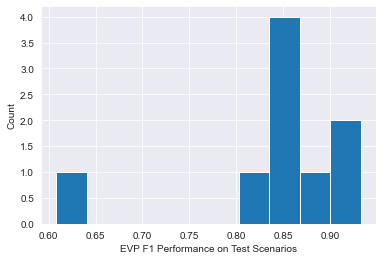

In [199]:
#plt.hist(indiv_scores)
plt.hist(evp_f1)
plt.ylabel("Count")
plt.xlabel("EVP F1 Performance on Test Scenarios")
plt.savefig("./Plots/evp_f1_performance.pdf",bbox_inches="tight")

914


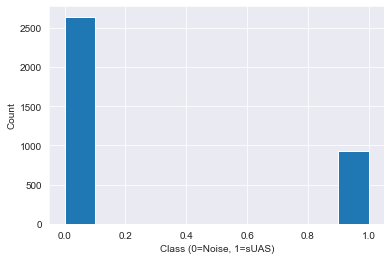

In [154]:
print(tot_test_time)
plt.hist(test_truth_evp)
#plt.hist(np.array(test_truth_indiv,int))
plt.ylabel("Count")
plt.xlabel("Class (0=Noise, 1=sUAS)")
plt.savefig("./Plots/evp_test_distro_hist.pdf",bbox_inches="tight")

#plt.hist(np.array(test_truth_indiv,int))

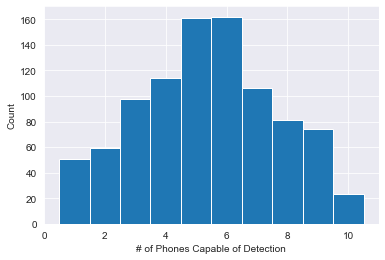

In [114]:
plt.xlabel("# of Phones Capable of Detection")
plt.ylabel("Count")
plt.hist(np.array(detectable_count),bins=range(1,12),align="left",rwidth=1)
plt.savefig("./Plots/number_of_detectable_phones.pdf",bbox_inches="tight")

In [49]:
np.average(time_per_prediction)

0.00012533999900021776

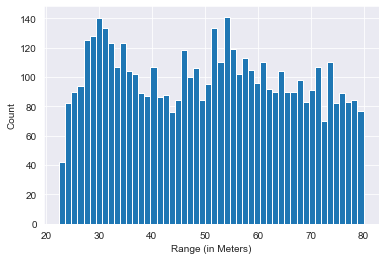

In [90]:
plt.hist(total_ranges,bins=50)
plt.ylabel("Count")
plt.xlabel("Range (in Meters)")
plt.savefig("./Plots/cellphone_test_ranges_hist_LT80.pdf",bbox_inches="tight")


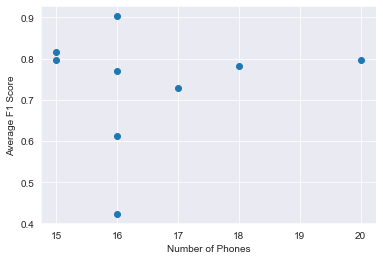

In [216]:
phone_count=np.array(phone_count)
plt.ylabel("Average F1 Score")
plt.xlabel("Number of Phones")
#plt.title("F1 Scores vs Phone Dropout")
plt.scatter(phone_count[:,0],phone_count[:,1])
plt.savefig("./Plots/Cellphone_resiliency_with_celldropout_svm.pdf",bbox_inches="tight")

# Barplot of Sensor Predictions

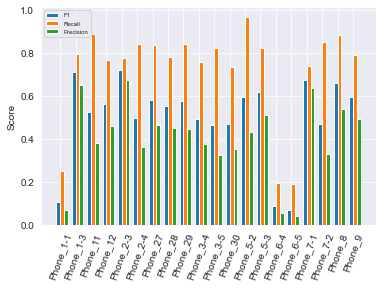

In [215]:
f1_average_values=[]
recall_average_values=[]
prec_average_values=[]
names=[]
ind=np.arange(20)
width=0.25
for x in indiv_phone_f1_dict:
    if len(indiv_phone_f1_dict[x])>0:
        names.append(x)
        f1_average_values.append(np.average(indiv_phone_f1_dict[x]))
        recall_average_values.append(np.average(indiv_phone_recall_dict[x]))
        prec_average_values.append(np.average(indiv_phone_prec_dict[x]))
bar1=plt.bar(ind,np.array(f1_average_values),align='edge',width=width)
bar2=plt.bar(ind+width,np.array(recall_average_values),align='edge',width=width)
bar3=plt.bar(ind+2*width,np.array(prec_average_values),align='edge',width=width)
plt.legend( (bar1, bar2, bar3), ('F1', 'Recall', 'Precision'),loc="upper left", prop={'size':6})
plt.xticks(ind+width,names)

plt.xticks(rotation=70)
plt.ylabel("Score")
plt.savefig("./Plots/F1_Score_Devices_SVM.pdf",bbox_inches="tight")

# F1 Score Comparison

0.5570062373190922
0.5008154918356451


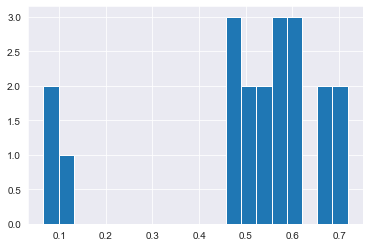

In [217]:
from scipy import stats
plt.hist(f1_average_values,bins=20)
plt.savefig("./Plots/F1_Score_distro_svm.pdf",bbox_inches="tight")
print(np.median(np.array(f1_average_values)[~np.isnan(f1_average_values)]))
print(np.average(np.array(f1_average_values)[~np.isnan(f1_average_values)]))

# Resiliency Measure

In [38]:
res_indiv_recall=[]
res_indiv_prec=[]
res_indiv_f1=[]
res_indiv_acc=[]
res_evp_recall=[]
res_evp_prec=[]
res_evp_f1=[]
res_evp_acc=[]

In [110]:
res_indiv_recall=[]
res_indiv_prec=[]
res_indiv_f1=[]
res_indiv_acc=[]
res_evp_recall=[]
res_evp_prec=[]
res_evp_f1=[]
res_evp_acc=[]
import random
def randomNumbers(n,max):
    values=[]
    for x in range(0,n):
        new=False
        while new!=True:
            val=random.randint(0,max)
            if not (val in values):
                values.append(val)
                new =True
    return values


def majorityVoteResiliency(testFeats, fusionThresh,networkThresh, FSMVal):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        #features_list= np.reshape(features_list, (len(features_list), 40, 1))
        maxVals.append(maxValues(features_list))
        pred=loaded_network.predict(features_list)[:] > networkThresh
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    predictedList=[]
    indiv_predictedList=[]
    truth_valueList=[]
    random_values=randomNumbers(14,(len(y_prediction)-1))
    y_prediction[random_values[0]]=~y_prediction[random_values[0]]
    y_prediction[random_values[1]]=~y_prediction[random_values[1]]
    y_prediction[random_values[2]]=~y_prediction[random_values[2]]
    y_prediction[random_values[3]]=~y_prediction[random_values[3]]
    y_prediction[random_values[4]]=~y_prediction[random_values[4]]
    y_prediction[random_values[5]]=~y_prediction[random_values[5]]
    y_prediction[random_values[6]]=~y_prediction[random_values[6]]
    y_prediction[random_values[7]]=~y_prediction[random_values[7]]
    y_prediction[random_values[8]]=~y_prediction[random_values[8]]
    y_prediction[random_values[9]]=~y_prediction[random_values[9]]
    # y_prediction[random_values[10]]=~y_prediction[random_values[10]]
    # y_prediction[random_values[11]]=~y_prediction[random_values[11]]
    # y_prediction[random_values[12]]=~y_prediction[random_values[12]]
    # y_prediction[random_values[13]]=~y_prediction[random_values[13]]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >fusionThresh: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        indiv_predictedList.append(best_indiv_predict)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,indiv_predictedList,truth_valueList
for x in range(4):
    novelAve=[]
    sumAve=[]
    outPerform=[]
    recall=[]
    precision=[]
    recall_stddev=[]
    score_stddev=[]
    phone_count=[]
    indiv_precisions=[]
    indiv_recalls=[]
    indiv_accuracies=[]
    indiv_scores=[]
    total_pred=[]
    total_truth=[]
    total_ranges=[]
    time_per_prediction=[]
    evp_f1=[]
    for x in range(18):
        #read scenario and truth data
        truthScenario = truthData.iloc[x]
        pass_num=truthScenario[0]
        scenario=truthScenario[1]
        run_num=truthScenario[2]
        start=truthScenario[3]
        stop=truthScenario[4]
        drone_gps_file=truthScenario[5]
        start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
        stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
        testTime= int(stop_time-start_time)
        full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
        print(full_name)
        if full_name not in tuning_runs and full_name not in bad_runs:
            dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\A3\\"+full_name
            Testdata_dir = pathlib.Path(dataset_path)
            phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
            # convert to MFCC space
            featuresLL =create_test_dataset(phones, testTime, testName=full_name)
            predictedList, y_prediction,indiv_predictedList,truth_valueList= majorityVoteResiliency(featuresLL,fusionThresh=0.2,networkThresh=0.90,FSMVal=2)
            # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
            #fusion_prediction, y_prediction = majorityVoteNew(featuresLL)
            #
            num_frames=len(predictedList) #length of one scenario in frames
            # y_actual=np.zeros(num_frames)
            # y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
            # Report balanced accuracy scores
            tot_indiv_score=0
            tot_recall_score=0
            tot_precision_score=0
            for z in range(len(featuresLL)):
                if len(featuresLL[z][2]>0):
                    for range_val in range(len(featuresLL[z][2])):
                        if featuresLL[z][2][int(range_val)]<80:
                            total_ranges.append(featuresLL[z][2][int(range_val)])
                    val=featuresLL[z][2]<80
                    phone_name=featuresLL[z][0]
                    if phone_name== "Phone_1-1":
                        print("USED HERE")
                        print(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                        print("--------------")
                    total_truth.extend(val)
                    total_pred.extend(y_prediction[z][0:len(val)])
                    indiv_phone_f1_dict[phone_name].append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                    indiv_phone_recall_dict[phone_name].append(recall_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                    indiv_phone_prec_dict[phone_name].append(precision_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                    indiv_accuracies.append(accuracy_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                    indiv_recalls.append(recall_score(val,y_prediction[z][0:len(val)]))
                    indiv_precisions.append(precision_score(val,y_prediction[z][0:len(val)]))
                    indiv_scores.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
            #################### Score Reporting #################
            indiv_score_ave=np.average(indiv_scores)
            print(full_name)
            print("Number of used phones:",len(y_prediction))
            fusion_score=accuracy_score(y_true=truth_valueList,y_pred=predictedList)
            fusion_f1_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
            novelAve.append(fusion_score)
            phone_count.append([len(y_prediction),fusion_f1_score])
            # print("Average Recall value:", recall_score(truth_valueList,predictedList))
            # print("Average Precision value:", precision_score(truth_valueList,predictedList))
            # print("Accuracy for drone present:", fusion_score)
            # print("Indiv Accuracy for drone present:", indiv_score_ave)
            performanceGain=100*((fusion_f1_score-indiv_score_ave)/indiv_score_ave)
            evp_f1.append(fusion_f1_score)
            outPerform.append(performanceGain)
            recall.append(recall_score(truth_valueList,predictedList))
            precision.append(precision_score(truth_valueList,predictedList))

    res_indiv_recall.append(np.average(indiv_recalls))
    res_indiv_prec.append(np.average(indiv_precisions))
    res_indiv_f1.append(np.average(indiv_scores))
    res_indiv_acc.append(np.average(indiv_accuracies))
    res_evp_recall.append(np.average(recall))
    res_evp_prec.append(np.average(precision))
    res_evp_acc.append(np.average(novelAve))
    res_evp_f1.append(np.average(evp_f1))

A3R3P1
A3R3P2
12/12 [==============================] - 0s 929us/step
A3R3P2
Number of used phones: 16
A3R3P3
12/12 [==============================] - 0s 1ms/step
A3R3P3
Number of used phones: 17
A3R3P4
A3R3P5
A3R4P1
12/12 [==============================] - 0s 934us/step
USED HERE
0.0
--------------
A3R4P1
Number of used phones: 20
A3R4P2
A3R4P3
12/12 [==============================] - 0s 959us/step
USED HERE
0.16836734693877553
--------------
A3R4P3
Number of used phones: 18
A3R4P4
A3R4P5
A3R5P1
14/14 [==============================] - 0s 732us/step
USED HERE
0.17449664429530198
--------------
A3R5P1
Number of used phones: 16
A3R5P2
14/14 [==============================] - 0s 775us/step
USED HERE
0.0
--------------
A3R5P2
Number of used phones: 15
A3R5P3
A3R5P4
14/14 [==============================] - 0s 1ms/step
USED HERE
0.17167381974248924
--------------
A3R5P4
Number of used phones: 15
A3R6P1
A3R6P2
12/12 [==============================] - 0s 1ms/step
A3R6P2
Number of used phones: 

In [111]:
print(np.average(res_evp_acc))
print(np.average(res_evp_recall))
print(np.average(res_evp_prec))
print(np.average(res_evp_f1))
print("______________")
print(np.average(res_indiv_acc))
print(np.average(res_indiv_recall))
print(np.average(res_indiv_prec))
print(np.average(res_indiv_f1))

0.26045865418172004
0.992508730683382
0.2590581497078239
0.4108493986302751
______________
0.41066551992365397
0.4984418975444642
0.2746380304070396
0.2811195943588879


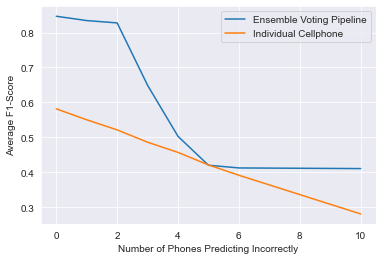

In [113]:
num_flipped=[0,1,2,3,4,5,6,10]
evp_f1=[84.66,83.42,82.75,64.90,50.29,42.04,41.26,41.08]
indiv_f1=[58.17,55.04,52.15,48.62,45.71,42.12,39.17,28.11]
plt.xlabel("Number of Phones Predicting Incorrectly")
plt.ylabel("Average F1-Score")

plt.plot(num_flipped,np.array(evp_f1)/100,label="Ensemble Voting Pipeline")
plt.plot(num_flipped,np.array(indiv_f1)/100,label="Individual Cellphone")
plt.legend()
plt.savefig("./Plots/resiliency_flipped_plot.pdf",bbox_inches="tight")

There is a large standard deviation amongst individual cellphone scores which demonstrates that some cellphones have internal microphone issues that may have caused error rates to be higher in some phones compared to others.

In [9]:
print(np.average(precision_stddev))
print(np.average(recall_stddev))
print(np.average(score_stddev))
print(np.average(phone_count))

0.18694290918863632
0.19525599810388333
0.09836653777221113
19.0


# Just majority vote Scoring

In [142]:
def majorityVoteAlone(testFeats, fusionThresh,networkThresh, FSMVal):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        if len(x[2]) > 0:
            #features_list= np.reshape(features_list, (len(features_list), 40, 1))
            maxVals.append(maxValues(features_list))
            start_time=time.perf_counter()
            pred=loaded_network.predict(features_list)[:] > networkThresh
            end_time=time.perf_counter()
            time_per_prediction.append((end_time-start_time)/len(pred))
            pred.astype(int)
            #pred = model.predict(x.squeeze()) #for SVM
            y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    fusionThresh_=6/numPhones
    predictedList=[]
    indiv_predictedList=[]
    truth_valueList=[]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1
                #predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >fusionThresh_: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(predictedVal)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        indiv_predictedList.append(best_indiv_predict)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,indiv_predictedList,truth_valueList
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\test_data\drone_test_truth_data_within_233m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
for x in range(13):
    truthScenario = truthData.iloc[x]
    if truthScenario[0] not in tuning_runs:
        #read scenario and truth data
        truthScenario = truthData.iloc[x]
        name=truthScenario[0]
        startDetect= truthScenario[1]
        endDetect=truthScenario[2]
        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_\\A3\\"+name
        Testdata_dir = pathlib.Path(dataset_path)
        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
        # convert to MFCC space
        testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
        # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
        fusion_prediction, y_prediction = majorityVoteAlone(featuresLL,0.78)
        #
        num_frames=len(fusion_prediction) #length of one scenario in frames
        y_actual=np.zeros(num_frames)
        y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
        # Report balanced accuracy scores
        tot_indiv_score=0
        for y in y_prediction:
            indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
            #print(indiv_score)
            tot_indiv_score+= indiv_score
        tot_indiv_score=tot_indiv_score/len(y_prediction)

        #################### Score Reporting #################
        print(name)
        print("Number of used phones:",len(y_prediction))
        print("Average Value:", tot_indiv_score)
        sumAve.append(tot_indiv_score)
        fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
        novelAve.append(fusion_score)
        print("Accuracy for drone present:", fusion_score)
        performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
        outPerform.append(performanceGain)
        recall.append(recall_score(y_actual,fusion_prediction))
        precision.append(precision_score(y_actual,fusion_prediction))
        print("Recall score:", recall_score(y_actual,fusion_prediction))
        print("Novel method outperforms by:", performanceGain, "%")
        print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

TypeError: create_test_dataset() missing 1 required positional argument: 'testName'

# Majority Vote with Weighting

In [36]:

def majorityVoteWithWeighting(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        # x -= mean
        # x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        #pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        pred= loaded_network.predict(x)[:] > 0.78
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    prevState=5
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                predictedDrone+= 1*maxValueRankArr[i][j]
                #predictedDrone+= 1

        if predictedDrone/maxVote >0.5: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        predictedList.append(predictedVal)

    return predictedList, y_prediction
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\test_data\drone_test_truth_data_within_233m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
for x in range(13):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    if truthScenario[0] not in tuning_runs:
        name=truthScenario[0]
        startDetect= truthScenario[1]
        endDetect=truthScenario[2]
        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
        Testdata_dir = pathlib.Path(dataset_path)
        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
        # convert to MFCC space
        testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
        # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
        fusion_prediction, y_prediction = majorityVoteWithWeighting(featuresLL)
        #
        num_frames=len(fusion_prediction) #length of one scenario in frames
        y_actual=np.zeros(num_frames)
        y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
        # Report balanced accuracy scores
        tot_indiv_score=0
        for y in y_prediction:
            indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
            #print(indiv_score)
            tot_indiv_score+= indiv_score
        tot_indiv_score=tot_indiv_score/len(y_prediction)

        #################### Score Reporting #################
        print(name)
        print("Number of used phones:",len(y_prediction))
        print("Average Value:", tot_indiv_score)
        sumAve.append(tot_indiv_score)
        fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
        novelAve.append(fusion_score)
        print("Accuracy for drone present:", fusion_score)
        performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
        outPerform.append(performanceGain)
        recall.append(recall_score(y_actual,fusion_prediction))
        precision.append(precision_score(y_actual,fusion_prediction))
        print("Recall score:", recall_score(y_actual,fusion_prediction))
        print("Novel method outperforms by:", performanceGain, "%")
        print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

22/22 [==============================] - 0s 4ms/step
A3R3P2
Number of used phones: 19
Average Value: 0.7691318814277073
Accuracy for drone present: 0.9281609195402298
Recall score: 0.9222797927461139
Novel method outperforms by: 20.676432995772277 %
_________________________
22/22 [==============================] - 0s 5ms/step
A3R3P3
Number of used phones: 20
Average Value: 0.7692528735632185
Accuracy for drone present: 0.9209770114942529
Recall score: 0.8652849740932642
Novel method outperforms by: 19.723571161748218 %
_________________________
22/22 [==============================] - 0s 4ms/step
A3R4P3
Number of used phones: 22
Average Value: 0.7285135841170323
Accuracy for drone present: 0.9267241379310345
Recall score: 0.8507462686567164
Novel method outperforms by: 27.20753025549083 %
_________________________
22/22 [==============================] - 0s 4ms/step
A3R5P2
Number of used phones: 19
Average Value: 0.7065184513006656
Accuracy for drone present: 0.9152298850574713
Recall